<a href="https://colab.research.google.com/github/hafizen/AI-PYTHON-case-study-romanian-problem-model/blob/main/RL_Hafiz_Kurniawan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reinforcement Learning pada Game CartPole**
Nama  : Hafiz Kurniawan <br>
NRP : 5025201032 <br>
Kelas : Deep Learning <br>
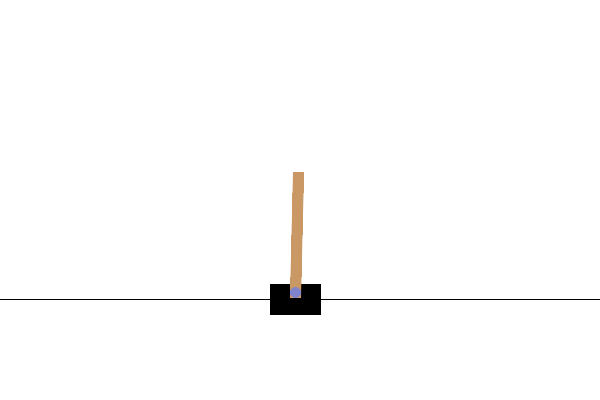
### **Cartpole**
Game Cartpole merupakan suatu game klasik dimana permainan untuk mengendalikan keseimbangan tiang di atas box. Dalam game ini, pemain dihadapkan pada tugas untuk menjaga tiang agar tetap berdiri tegak diatas box yang bergerak di sepanjang lintasan satu dimensi. Tantangannya berada pada keseimbangan tiang. Tiang tersebut rentan terhadap pergerakan, sehingga mudah terjatuh jika tidak dikendalikan. Pemain harus bereaksi dengan cepat dan tepat untuk menyesuaikan arah kereta sehingga tiang tetap seimbang dan tidak jatuh.

### **Reinforcement Learning**
pada game ini Reinforcement Learning digunakan untuk belajar secara mandiri mengendalikan box dan menjaga tiang  agar tetap seimbang.  

## **Identifikasi Komponen Cartpole**
### **State**
bentuk representasi keadaan saat ini pada Cartpole:
*   posisi box cart pada track
*   kecepatan box cart
*   sudut tiang pole
*   kecepatan rotasi tiang pole

### **Action**
Tindakan yang dapat diterapkan:
*   Menggerakkan box cart ke kanan
*   Menggerakkan box cart ke kiri
*   Tidak menggerakkan box cart

### **Environment**
Tempat dimana sistem beroperasi:
*   Sistem box cart dan tiang pole
*   Hukum gerak yang mempengaruhinya

### **Reward**
Umpan balik kepada agen dari environment setelah melakukan action:
*   Agen mendapatkan reward +1 untuk setiap langkah waktu dimana tiang tetap berdiri tegak
*   Episode berakhir jika tiang pole jatuh atau jika box bergerak keluar dari batas lintasan yang ditentukan

### **Policy**
Strategi agen untuk memilih action berdasarkan state saat ini:
*   Fungsi probabilitas yang memetakan state ke action untuk memaksimalkan total reward.













## **Implementasi Reinforcement Learning**

## **SETUP**
### instalasi paket yang digunakan

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.1'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet xvfbwrapper
!pip install tf-keras

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 2s (109 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest vers

### Menggunakan lingkungan Keras-2

In [ ]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

### Import modul

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## **HYPERPARAMETER**


In [ ]:
env_name = "CartPole-v0" # @param {type:"string"}
num_iterations = 300 # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
replay_buffer_capacity = 2000 # @param {type:"integer"}

# layer with 100 neuron
fc_layer_params = (100,)

learning_rate = 0.001 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 50 # @param {type:"integer"}

## **ENVIRONMENT**


In [ ]:
env = suite_gym.load(env_name)

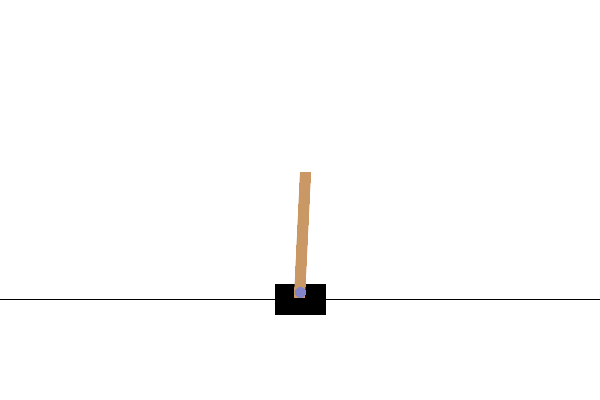

In [ ]:
env.reset()
PIL.Image.fromarray(env.render())

In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [ ]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.0226283 , -0.03645627, -0.02101954,  0.01482715], dtype=float32)})
Next time step:
TimeStep(
{'step_type': array(1, dtype=int32),
 'reward': array(1., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.02335743,  0.15896071, -0.02072299, -0.2844129 ], dtype=float32)})


In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## **AGENT**

In [ ]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

## **POLICY**

agent.policy untuk evaluasi/kebijakan<br>
agent.collect_policy untuk mengoleksi data

In [ ]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

metrik evaluasi average return (avg_return)

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


In [ ]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      tf_agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
      replay_buffer_signature)
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    table_name=table_name,
    sequence_length=None,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

In [ ]:
def collect_episode(environment, policy, num_episodes):

  driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(
      policy, use_tf_function=True),
    [rb_observer],
    max_episodes=num_episodes)
  initial_time_step = environment.reset()
  driver.run(initial_time_step)

## **TRAINING AGENT**

In [ ]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_py_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  iterator = iter(replay_buffer.as_dataset(sample_batch_size=1))
  trajectories, _ = next(iterator)
  train_loss = tf_agent.train(experience=trajectories)

  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 25: loss = 1.0987977981567383
step = 50: loss = 1.0150346755981445
step = 50: Average Return = 9.5
step = 75: loss = 1.2682404518127441
step = 100: loss = 1.2246445417404175
step = 100: Average Return = 9.100000381469727
step = 125: loss = 1.4175190925598145
step = 150: loss = 0.8554401397705078
step = 150: Average Return = 69.0
step = 175: loss = 0.8330074548721313
step = 200: loss = 0.32679080963134766
step = 200: Average Return = 195.10000610351562
step = 225: loss = 1.7427396774291992
step = 250: loss = -1.8829693794250488
step = 250: Average Return = 200.0
step = 275: loss = 4.5121378898620605
step = 300: loss = -2.072713613510132
step = 300: Average Return = 200.0


## **VISUALISASI**

(-0.44499959945678746, 250.0)

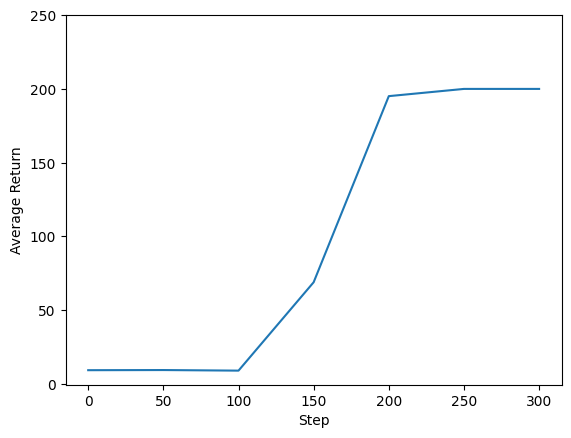

In [ ]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)

## **HASIL DAN PEMBAHASAN**
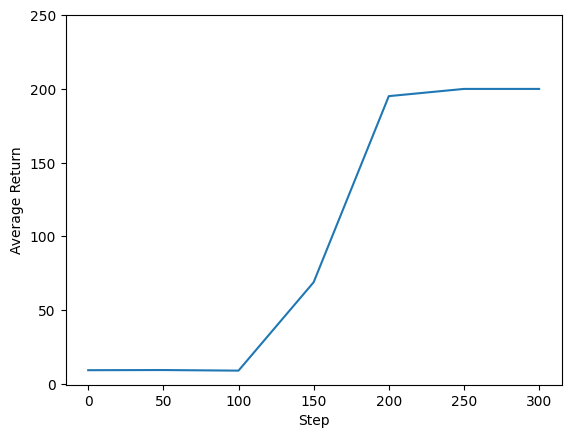
<br>Dalam Reinforcement Learning Cartpole, telah didefinisikan bahwa diberikan reward +1 untuk setiap langkah tiang pole tetap tegak. Dan karena jumlah langkah maksimum adalah 200, maka average return maksimum bernilai 200 juga.
Dalam pelatihan agen yang dilakukan dengan 300 step. dengan step satu hingga 100 nilai average return berada dibawah 10, yakni 9.100000381469727. ketika pelatihan agen hingga 200 step nilai average return naik signifikan hingga hampir menyentuh nilai maksimal, pada step 200, nilai average return mencapai 195.10000610351562. Akhirnya ketika memasuki step 250 agent telah mendapatkan nilai 200,maksimal dari average return. <br>

Agent Reinforcement Learning Cartpole, dapat melakukan pembelajaran mandiri terhadap Lingkungan Cartpole dengan baik, dengan 250 step dapat mendapatkan nilai maksimal dari lingkungan Cartpole.